In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.impute import KNNImputer

In [2]:
# load the dataset

df = pd.read_csv('merged_data_updated.csv')

In [3]:
print(df.columns)

Index(['date', 'warengruppe', 'id', 'umsatz', 'Bewoelkung', 'Temperatur',
       'Windgeschwindigkeit', 'Wettercode', 'KielerWoche', 'school_holiday',
       'public_holiday'],
      dtype='object')


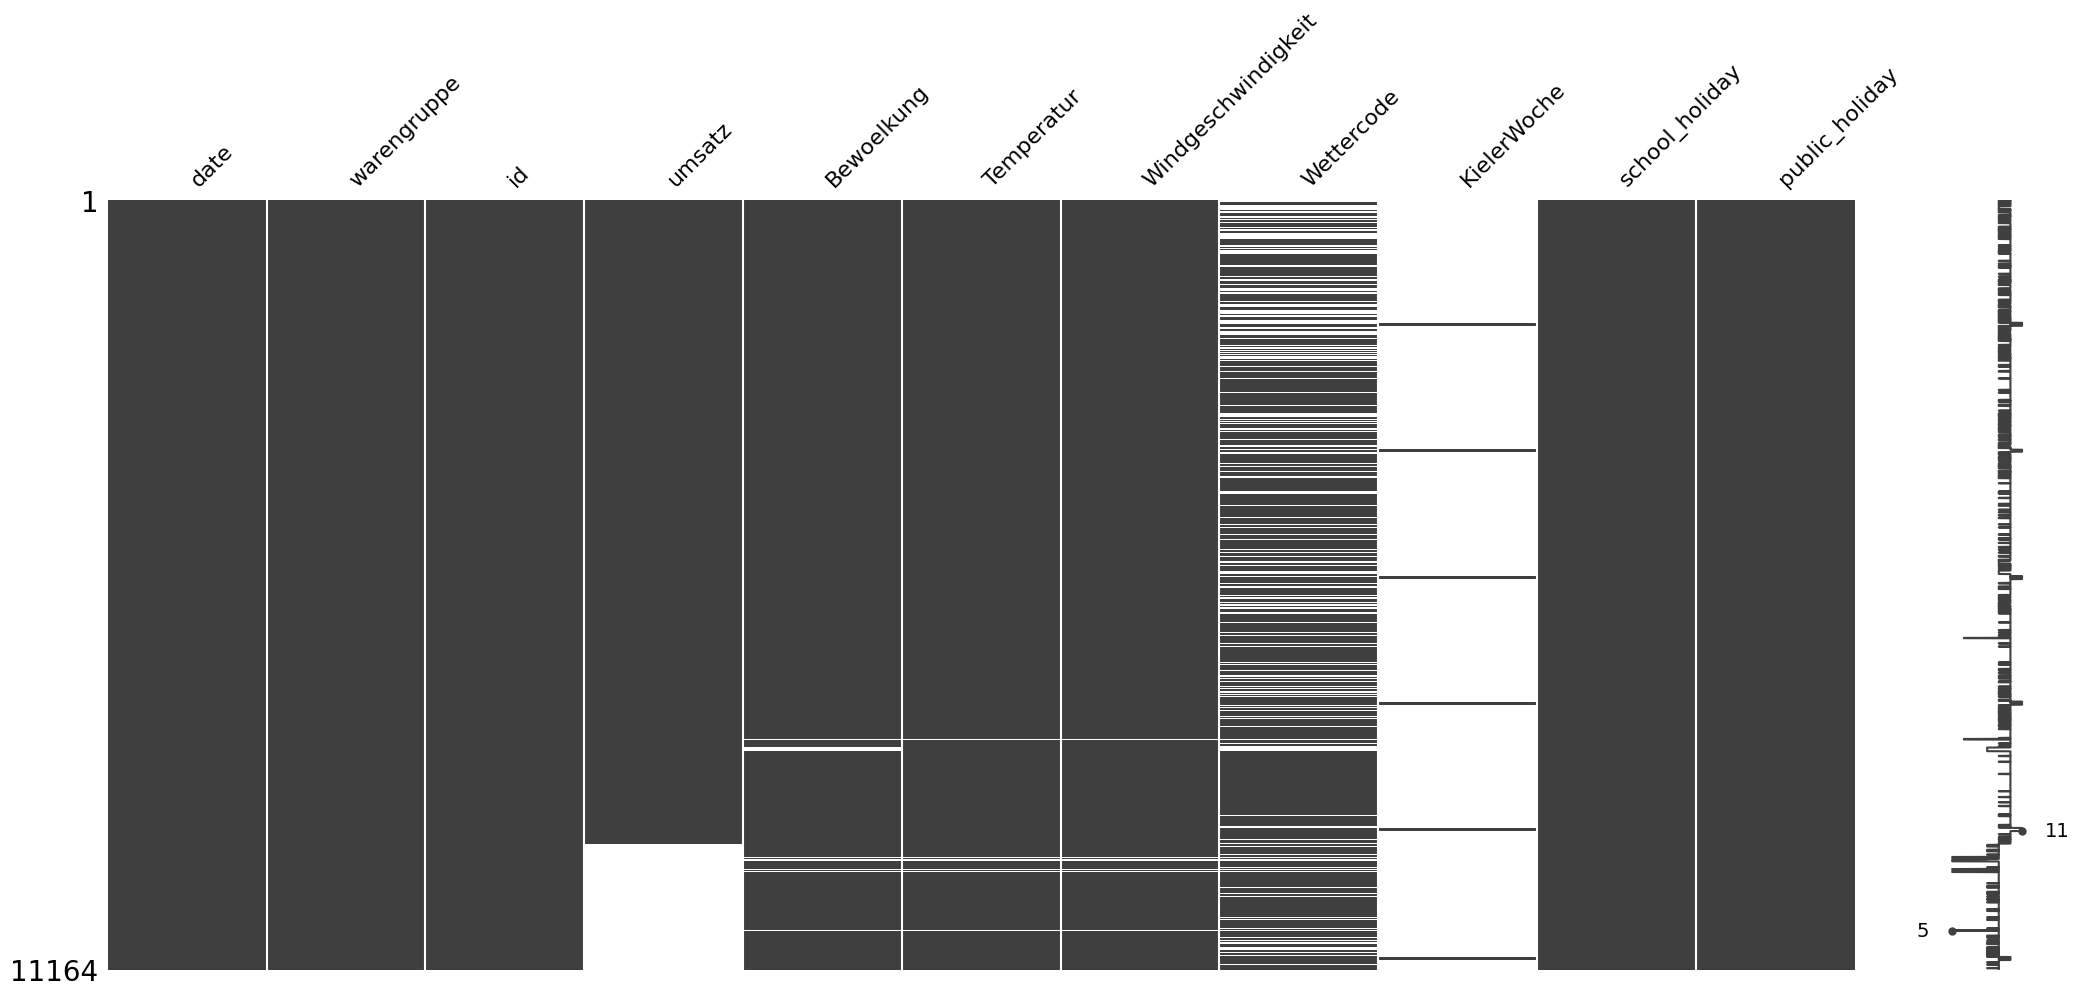

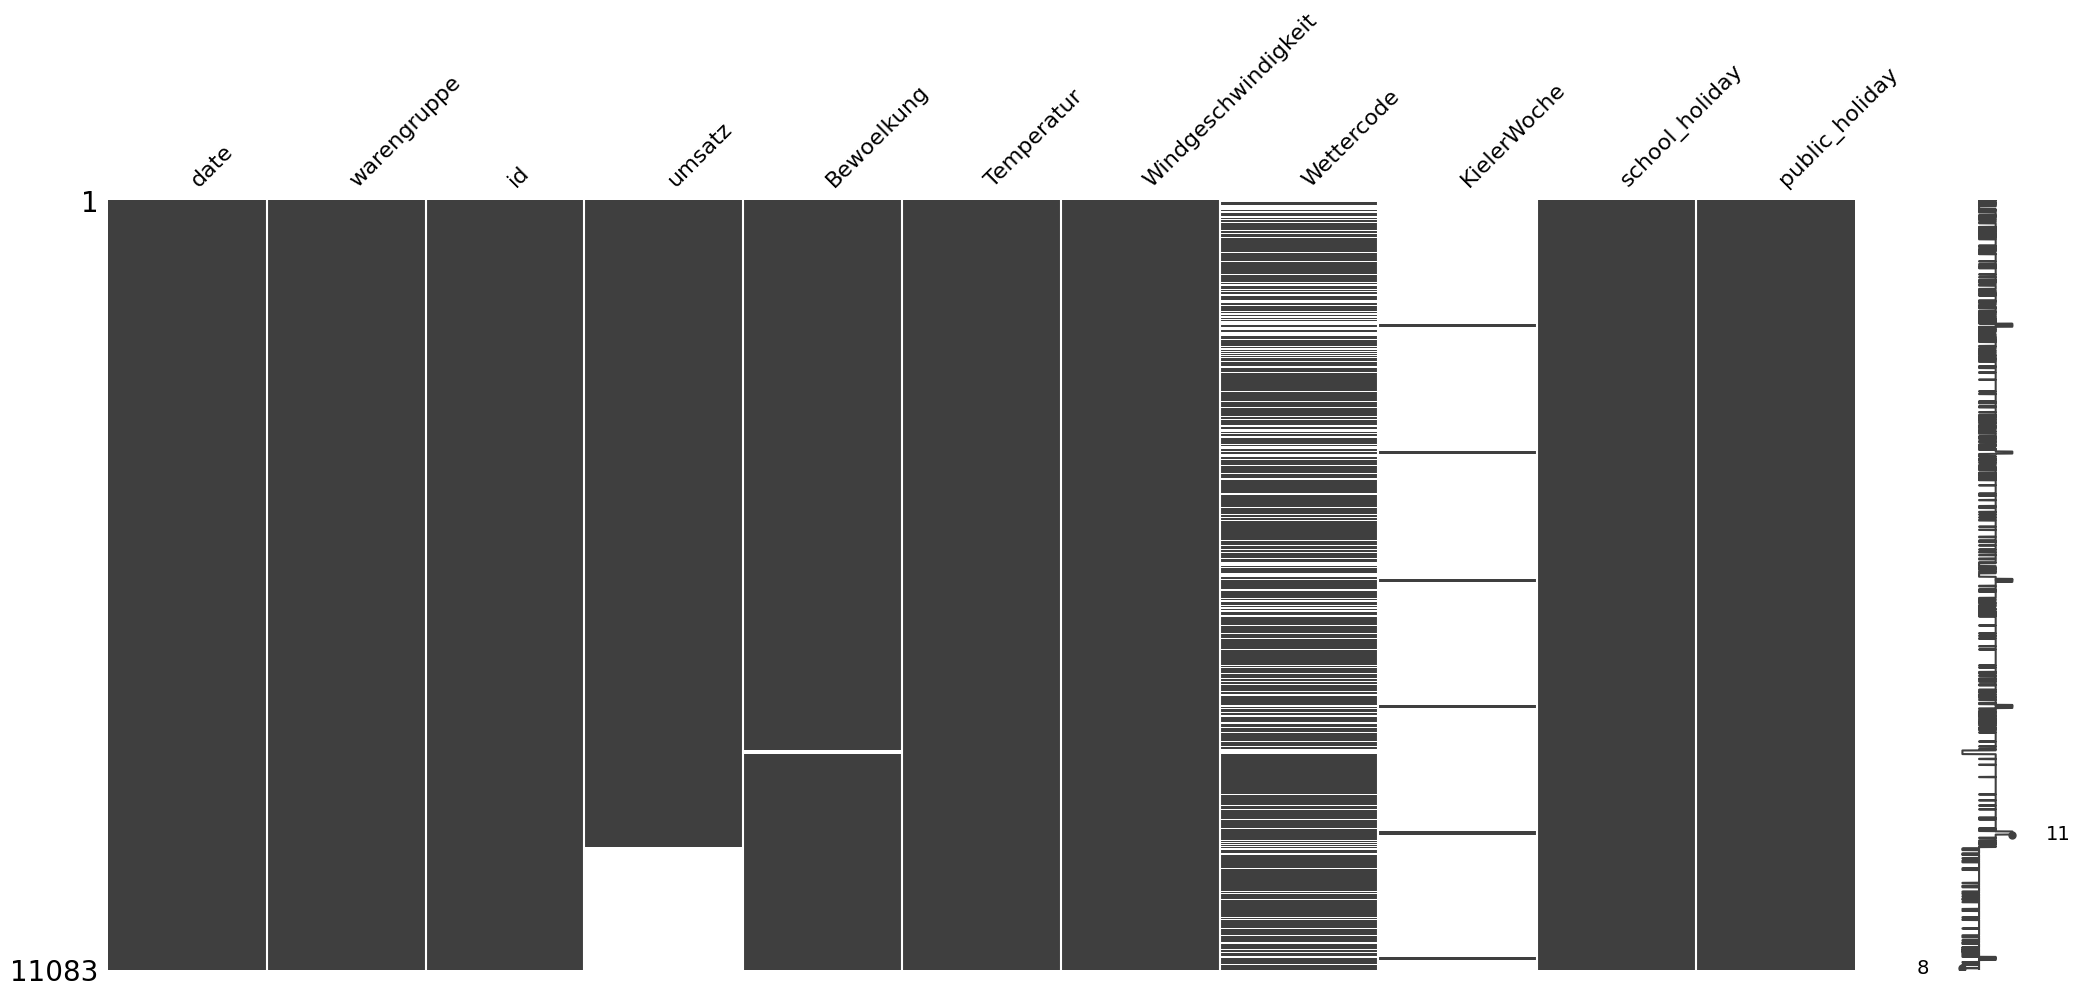

In [4]:
#drop in those rows where everything ist missing

daten_spalten=["Bewoelkung", "Temperatur", "Windgeschwindigkeit", "Wettercode", "KielerWoche"]

df_clean = df.dropna(subset=daten_spalten, how="all")

df_clean.to_csv("daten_bereinigt.csv", index=False)

# Visualize missing data before and after cleaning
msno.matrix(df)   
plt.show()

msno.matrix(df_clean)
plt.show()

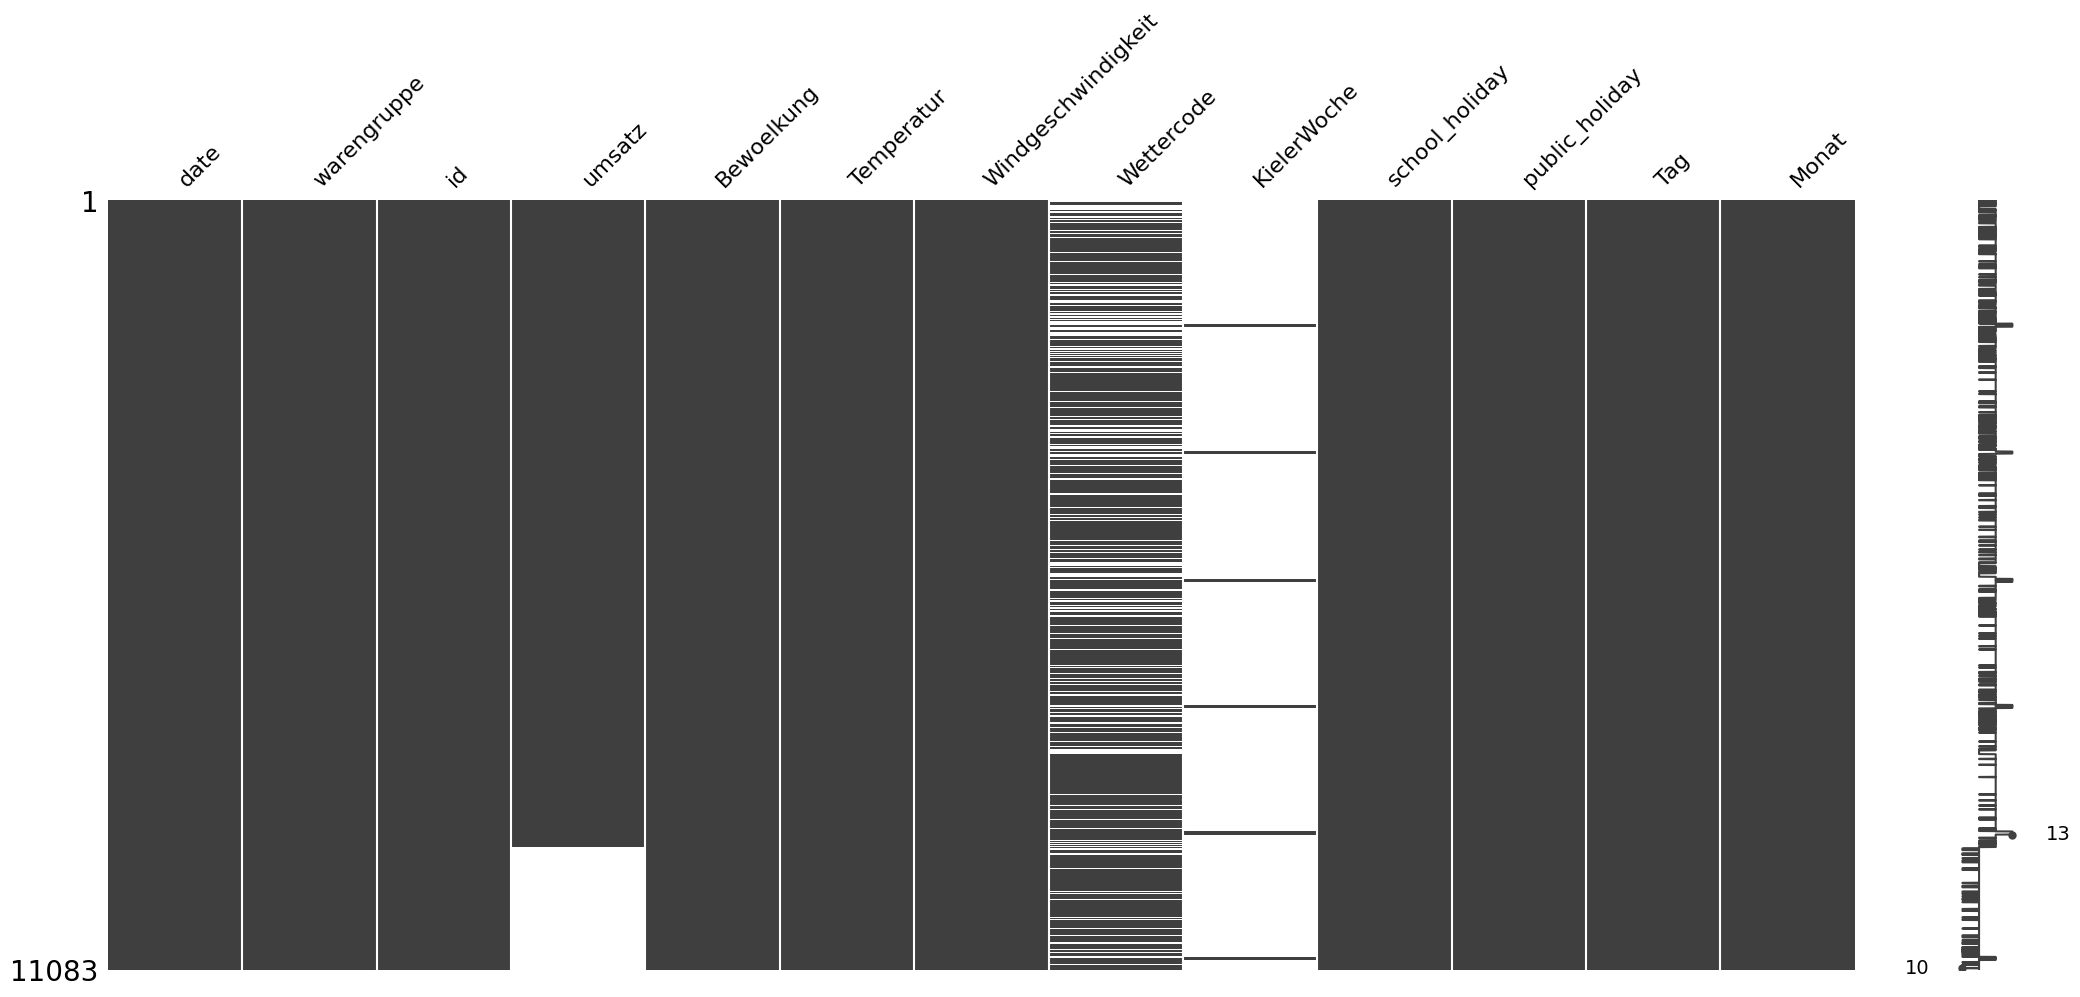

In [5]:
#filling the gap in Bewoelkung via historical data

import pandas as pd

df = pd.read_csv("daten_bereinigt.csv")

# Datumsspalte in datetime umwandeln
df['date'] = pd.to_datetime(df['date'])

wert_spalte = 'Bewoelkung'

df['Tag'] = df['date'].dt.day
df['Monat'] = df['date'].dt.month

# Berechne den historischen Durchschnitt für jeden Tag und Monat
historical_avg = df.groupby(['Monat', 'Tag'])[wert_spalte].mean()

def fill_with_historic(row):
    if pd.isna(row[wert_spalte]):
        return historical_avg.loc[(row['Monat'], row['Tag'])]
    else:
        return row[wert_spalte]


df[wert_spalte] = df.apply(fill_with_historic, axis=1)

df.to_csv("daten_mit_fuellung.csv", index=False)

msno.matrix(df)
plt.show()

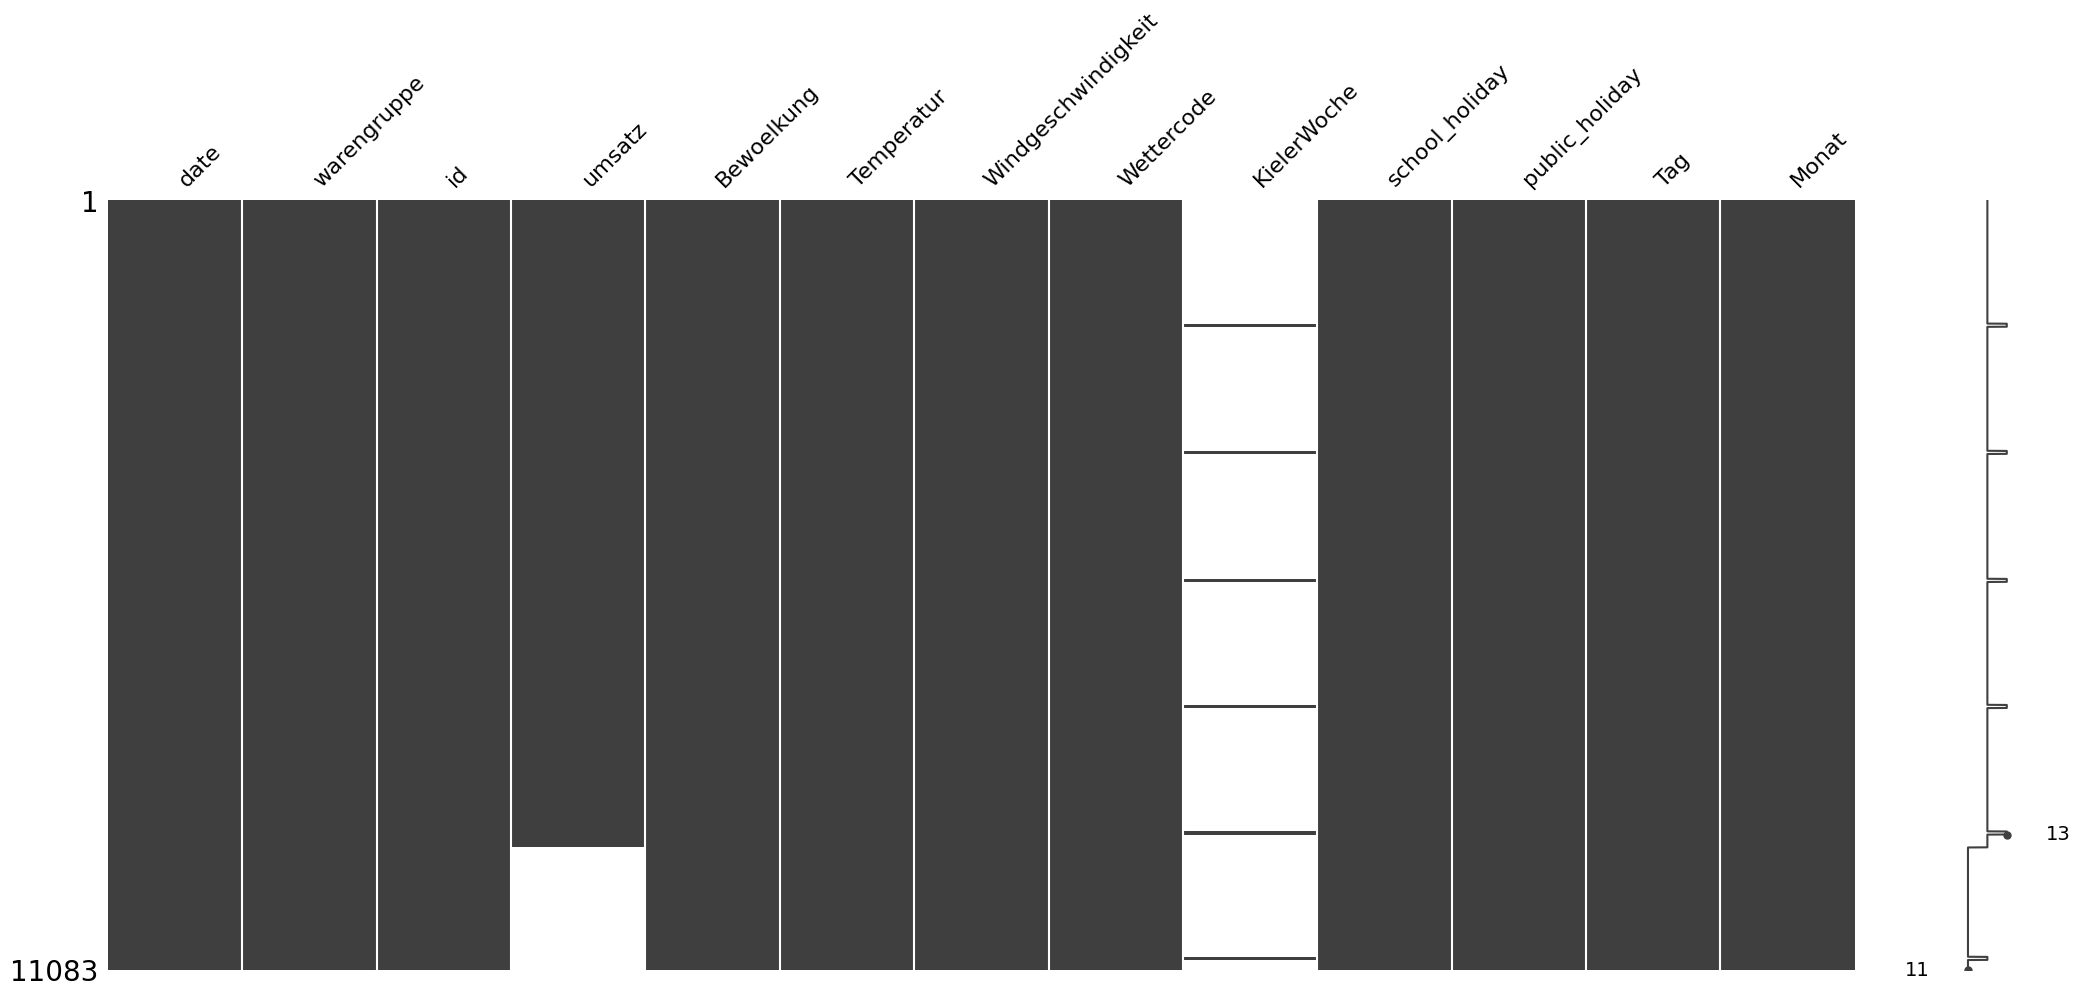

In [6]:
#iterative regression on Wettercode
import numpy as np
df = pd.read_csv("daten_mit_fuellung.csv")

# Spalten für den Imputer auswählen (nur numerische Spalten mit fehlenden Werten)
numerische_spalten = ['Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode']
df_numeric = df[numerische_spalten]

# Iterative Imputer einrichten
imputer = IterativeImputer(random_state=42, max_iter=10)

# Imputation durchführen
df_imputed_array = imputer.fit_transform(df_numeric)

# zurück in DataFrame
df_imputed = pd.DataFrame(df_imputed_array, columns=numerische_spalten)

#Anpassungen, da "Wettercode" kategorische Spalte
codes = df['Wettercode'].dropna().unique()
df_imputed['Wettercode'] = df_imputed['Wettercode'].apply(lambda x: codes[np.abs(codes - x).argmin()]).astype(int)

# Imputierte Werte zurück in den ursprünglichen DataFrame
df['Wettercode'] = df_imputed['Wettercode']

df.to_csv("daten_final_no_missing_data.csv", index=False)
msno.matrix(df)
plt.show()

In [7]:
#Kontrolle vor lineare regression

df = pd.read_csv("daten_final_no_missing_data.csv")

# Prozentualer Anteil fehlender Werte pro Spalte
missing_percent = df.isna().mean() * 100

print(missing_percent)

date                    0.000000
warengruppe             0.000000
id                      0.000000
umsatz                 15.925291
Bewoelkung              0.000000
Temperatur              0.000000
Windgeschwindigkeit     0.000000
Wettercode              0.000000
KielerWoche            97.581882
school_holiday          0.000000
public_holiday          0.000000
Tag                     0.000000
Monat                   0.000000
dtype: float64
